# 📘 CRISP-DM : Head & Shoulders Detection (LSTM-CNN)

🟦 Phase 1: Environment Setup

✅ Cell 1: Import Libraries

In [10]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML / DL
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,SpatialDropout1D,BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

# Cassandra
from cassandra.cluster import Cluster

# Seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


🟦 Phase 2: Data Understanding

✅ Cell 2: Connect to Cassandra & Fetch Data

In [11]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()
# 1. รายชื่อหุ้นที่ต้องการดึงจาก Cassandra
stock_list = ['PTT', 'ADVANC', 'TRUBB', 'TRUE', '3BBIF', 'BANPU', 'CPALL']

# 2. ตั้งค่า Keyspace
session.set_keyspace('stock_data')

all_stock_data = []

print("เริ่มดึงข้อมูลจาก Cassandra...")

for symbol in stock_list:
    # Query ข้อมูลรายตัว โดยกรองจาก symbol (สมมติว่าใน Table มีคอลัมน์ symbol)
    # หาก Table แยกตาม symbol ให้ปรับ Query เป็น FROM candlestick_data_{symbol} ตามโครงสร้างของคุณ
    query = f"SELECT time, open_price, high_price, low_price, close_price, volume FROM candlestick_data WHERE symbol = '{symbol}'"
    
    try:
        rows = session.execute(query)
        df_temp = pd.DataFrame(list(rows))
        
        if not df_temp.empty:
            # เพิ่มคอลัมน์ symbol เพื่อระบุว่าข้อมูลนี้ของหุ้นตัวไหน (สำคัญมากสำหรับตอน Scale และ Label)
            df_temp['symbol'] = symbol
            # เรียงลำดับเวลา
            df_temp = df_temp.sort_values('time').reset_index(drop=True)
            all_stock_data.append(df_temp)
            print(f"✅ ดึงข้อมูล {symbol} สำเร็จ: {len(df_temp)} แถว")
        else:
            print(f"⚠️ ไม่พบข้อมูลสำหรับ {symbol}")
            
    except Exception as e:
        print(f"❌ Error ในการดึง {symbol}: {e}")

# 3. รวมข้อมูลหุ้นทุกตัวเข้าด้วยกัน
if all_stock_data:
    df = pd.concat(all_stock_data, axis=0).reset_index(drop=True)
    print(f"\n--- สรุปการดึงข้อมูล ---")
    print(f"รวมข้อมูลทั้งหมด: {len(df)} แถว จากหุ้น {len(all_stock_data)} ตัว")
else:
    print("ไม่มีข้อมูลที่ถูกดึงมาได้เลย")

# แสดงตัวอย่างข้อมูล
df.head()


เริ่มดึงข้อมูลจาก Cassandra...
✅ ดึงข้อมูล PTT สำเร็จ: 729 แถว
✅ ดึงข้อมูล ADVANC สำเร็จ: 729 แถว
⚠️ ไม่พบข้อมูลสำหรับ TRUBB
⚠️ ไม่พบข้อมูลสำหรับ TRUE
✅ ดึงข้อมูล 3BBIF สำเร็จ: 729 แถว
✅ ดึงข้อมูล BANPU สำเร็จ: 729 แถว
✅ ดึงข้อมูล CPALL สำเร็จ: 729 แถว

--- สรุปการดึงข้อมูล ---
รวมข้อมูลทั้งหมด: 3645 แถว จากหุ้น 5 ตัว


,time,open_price,high_price,low_price,close_price,volume,symbol
0,2023-01-09,32.75,33.25,32.75,33.00,48837692,PTT
1,2023-01-10,33.25,33.25,32.75,33.25,39540053,PTT
2,2023-01-11,33.25,33.50,33.00,33.50,45435296,PTT
3,2023-01-12,33.50,33.75,33.25,33.75,41018316,PTT
4,2023-01-13,33.75,34.00,33.25,33.75,71005807,PTT


✅ Cell 3: EDA

In [12]:
# ✅ Cell 3: EDA & Basic Cleaning
print(f"จำนวนข้อมูลก่อนคลีน: {len(df)}")
df = df.dropna() # ลบแถวที่มีค่าว่าง
df = df.drop_duplicates(subset=['time', 'symbol']) # ลบข้อมูลซ้ำถ้ามี
df = df.sort_values(['symbol', 'time']).reset_index(drop=True)
print(f"จำนวนข้อมูลหลังคลีน: {len(df)}")

# ดูจำนวนข้อมูลรายคลาส
print("\nจำนวนข้อมูลต่อหุ้น:")
print(df['symbol'].value_counts())

จำนวนข้อมูลก่อนคลีน: 3645
จำนวนข้อมูลหลังคลีน: 3645

จำนวนข้อมูลต่อหุ้น:
symbol
3BBIF     729
ADVANC    729
BANPU     729
CPALL     729
PTT       729
Name: count, dtype: int64


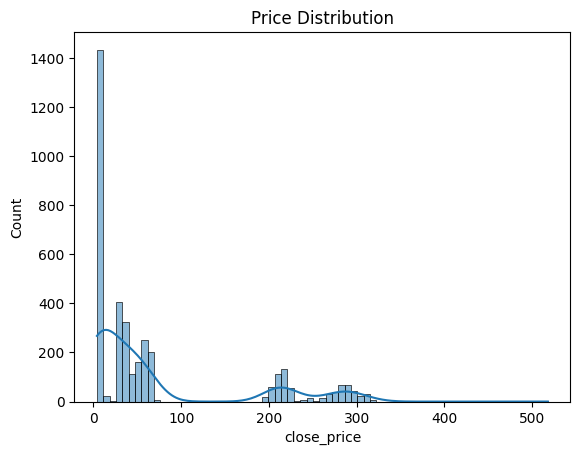

In [13]:
# Distribution
sns.histplot(df['close_price'], kde=True)
plt.title("Price Distribution")
plt.show()

In [14]:
# Missing Values
print(df.isnull().sum())

time           0
open_price     0
high_price     0
low_price      0
close_price    0
volume         0
symbol         0
dtype: int64


🟦 Phase 3: Data Preparation

✅ Cell 4: Scale Data (features only)

In [15]:
# ✅ Cell 4: Scale Data (Group by Symbol)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# สร้าง Column สำหรับเก็บค่าที่ Scale แล้ว
features = ['open_price', 'high_price', 'low_price', 'close_price', 'volume']
all_scaled_list = []

for symbol in df['symbol'].unique():
    subset = df[df['symbol'] == symbol][features].values
    scaled_subset = scaler.fit_transform(subset)
    all_scaled_list.append(scaled_subset)

# รวมเป็นก้อนเดียวเพื่อเข้า Model
all_scaled = np.vstack(all_scaled_list)
print("Shape ของข้อมูลที่ Scale แล้ว:", all_scaled.shape)

Shape ของข้อมูลที่ Scale แล้ว: (3645, 5)


✅ Cell 5: H&S Labeling Logic (จริง ไม่สุ่ม)

In [16]:
def detect_peaks_troughs(prices):
    peaks, troughs = [], []
    for i in range(1, len(prices)-1):
        if prices[i] > prices[i-1] and prices[i] > prices[i+1]:
            peaks.append(i)
        if prices[i] < prices[i-1] and prices[i] < prices[i+1]:
            troughs.append(i)
    return peaks, troughs


def label_hs_real(prices, tol=0.03):
    labels = np.zeros(len(prices))
    peaks, troughs = detect_peaks_troughs(prices)

    for i in range(len(peaks)-2):
        p1, p2, p3 = peaks[i:i+3]

        # Head must be highest
        if prices[p2] <= prices[p1] or prices[p2] <= prices[p3]:
            continue

        # Shoulder symmetry
        if abs(prices[p1] - prices[p3]) / prices[p2] > tol:
            continue

        # Troughs
        t1 = [t for t in troughs if p1 < t < p2]
        t2 = [t for t in troughs if p2 < t < p3]
        if not t1 or not t2:
            continue

        neckline = (prices[min(t1)] + prices[min(t2)]) / 2

        # Confirmation
        if p3+1 < len(prices) and prices[p3+1] < neckline:
            labels[p1] = 1
            labels[p2] = 2
            labels[p3] = 3

    return labels


df['hs_label'] = label_hs_real(df['close_price'].values)

print(df['hs_label'].value_counts())


hs_label
0.0    3568
1.0      26
2.0      26
3.0      25
Name: count, dtype: int64


✅ Cell 6: Sliding Window + Prepare Labels

In [17]:
def create_windows_augmented(X, y_labels, window_size=60):
    Xs, ys = [], []
    # เราใช้ Stride=1 เสมอในการวนลูปเพื่อความละเอียดสูงสุด
    for i in range(len(X) - window_size):
        # ดึงช่วง Label ใน Window นี้ออกมาดู
        window_labels = y_labels[i : i + window_size]
        
        # 🎯 กฎการขยาย Label (Spreading): 
        # ถ้าใน 60 แท่งเทียนนี้ มี Pattern ปรากฏอยู่ ให้ถือว่า Window นี้คือคลาสนั้นๆ
        if 2 in window_labels:
            ys.append(2) # Head
        elif 1 in window_labels:
            ys.append(1) # L.Shoulder
        elif 3 in window_labels:
            ys.append(3) # R.Shoulder
        else:
            ys.append(0) # None
            
        Xs.append(X[i : i + window_size])
        
    return np.array(Xs), np.array(ys)

# 1. รันการสร้าง Windows ด้วยวิธี Spreading
WINDOW = 60
X_all, y_all = create_windows_augmented(all_scaled, df['hs_label'].values, WINDOW)

# 2. ตรวจสอบจำนวนก่อนแบ่ง (ควรจะเพิ่มจาก 21 เป็นหลักร้อย/พัน)
print("--- จำนวน Windows ทั้งหมดหลังทำ Spreading ---")
print(pd.Series(y_all).value_counts())

# 3. แบ่งข้อมูล Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, 
    test_size=0.2, 
    stratify=y_all,      
    random_state=42,
    shuffle=True 
)

print("\n--- สรุปการกระจายข้อมูลสำหรับ Training ---")
print("Train distribution:\n", pd.Series(y_train).value_counts())
print("Test distribution:\n", pd.Series(y_test).value_counts())

--- จำนวน Windows ทั้งหมดหลังทำ Spreading ---
0    2109
2    1326
3      84
1      66
Name: count, dtype: int64

--- สรุปการกระจายข้อมูลสำหรับ Training ---
Train distribution:
 0    1687
2    1061
3      67
1      53
Name: count, dtype: int64
Test distribution:
 0    422
2    265
3     17
1     13
Name: count, dtype: int64


🟦 Phase 4: Modeling

✅ Cell 7: Hybrid CNN-LSTM Model

In [18]:
# Cell 7: ปรับปรุงโครงสร้าง


inputs = Input(shape=(WINDOW, X.shape[2]))

x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = SpatialDropout1D(0.2)(x) # ป้องกันการจำจุดราคาที่เฉพาะเจาะจงเกินไป

x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.4)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

NameError: name 'X' is not defined

✅ Cell 8: Model Training (แก้ตรงนี้)

In [ ]:
# 1. คำนวณน้ำหนักคลาส (Class Weights) 
# เพื่อบีบให้โมเดลสนใจคลาส 1, 2, 3 ที่มีข้อมูลน้อยมาก
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {
    0: 1.0, 
    1: 15.0, # ไหล่ยังน้อยอยู่ ให้ความสำคัญหน่อย
    2: 2.0,  # หัวเยอะแล้ว ลดน้ำหนักลงเพื่อไม่ให้ทายมั่ว
    3: 15.0  # ไหล่ยังน้อยอยู่
}
print("Class Weights Calculated:", class_weight_dict)

# 2. ตั้งค่า Callbacks เพื่อคุมความเสถียรของกราฟ
callbacks = [
    # หยุดเทรนถ้า Val Loss ไม่ดีขึ้น 12 รอบ ป้องกัน Overfitting
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    
    # บันทึกน้ำหนักที่ดีที่สุดไว้
    ModelCheckpoint("best_hs_model.keras", save_best_only=True, monitor='val_loss'),
    
    # ลด Learning Rate เมื่อการเรียนรู้เริ่มนิ่ง
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# 3. เริ่มการเทรน
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,   # สำคัญมาก: ช่วยแก้ปัญหา Imbalance
    callbacks=callbacks,
    verbose=1
)

Class Weights Calculated: {0: 1.0, 1: 15.0, 2: 2.0, 3: 15.0}
Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3748 - loss: 3.0979 - val_accuracy: 0.3696 - val_loss: 1.3567 - learning_rate: 2.5000e-05
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3738 - loss: 3.0839 - val_accuracy: 0.3696 - val_loss: 1.4071 - learning_rate: 2.5000e-05
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3835 - loss: 3.0198 - val_accuracy: 0.3696 - val_loss: 1.4369 - learning_rate: 2.5000e-05
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3835 - loss: 2.9956 - val_accuracy: 0.3696 - val_loss: 1.4459 - learning_rate: 2.5000e-05
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3839 - loss: 2.9572 - val_accuracy: 0.3696 - val_loss: 1.4359 - learning_rate: 2.5000e-05
Epoch 6/100
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3809 - loss: 2.9770
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-0

🟦 Phase 5: Evaluation

🔹 Cell 9: Training Health

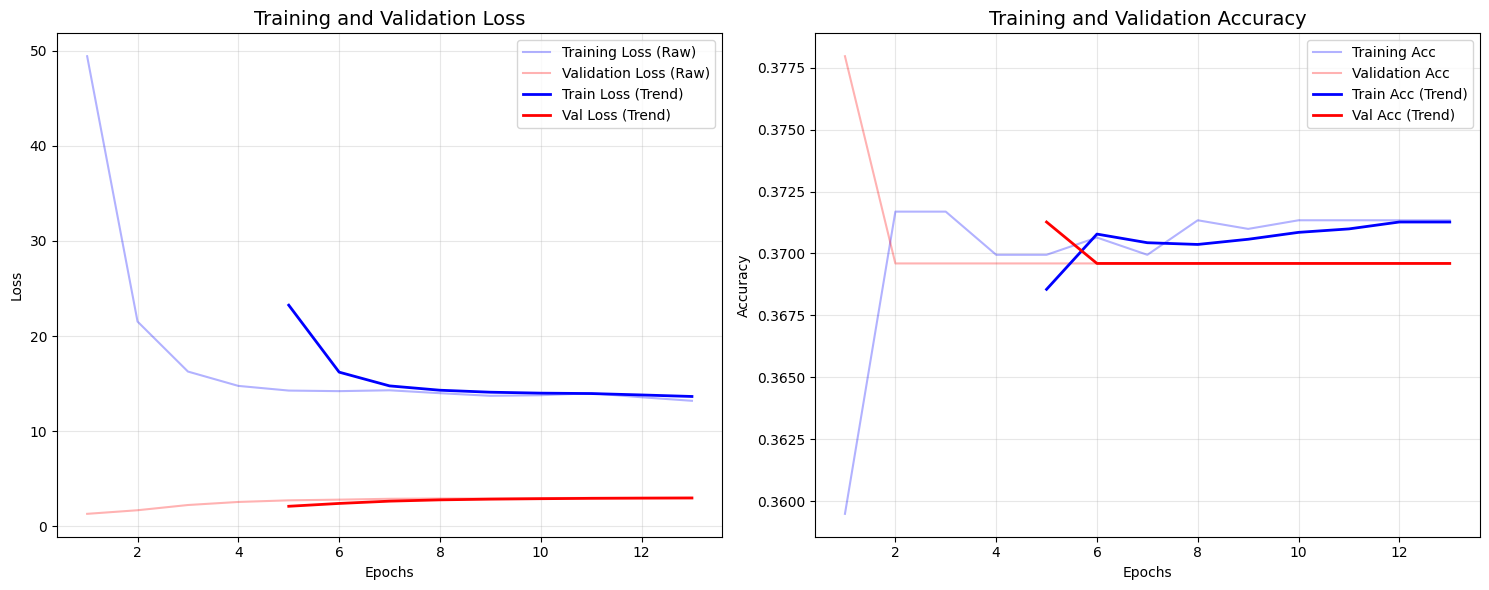

In [ ]:
def plot_learning_curves(history):
    """
    ฟังก์ชันสำหรับพล็อต Loss และ Accuracy ให้ดูง่ายและวิเคราะห์ปัญหาได้ชัดเจน
    """
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 6))

    # --- Plot 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', alpha=0.3, label='Training Loss (Raw)')
    plt.plot(epochs, val_loss, 'r-', alpha=0.3, label='Validation Loss (Raw)')
    
    # เพิ่ม Moving Average เพื่อดู Trend (กรณี Loss ผันผวน)
    if len(loss) > 5:
        plt.plot(epochs[4:], pd.Series(loss).rolling(5).mean()[4:], "b-", linewidth=2, label='Train Loss (Trend)')
        plt.plot(epochs[4:], pd.Series(val_loss).rolling(5).mean()[4:], "r-", linewidth=2, label='Val Loss (Trend)')

    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # --- Plot 2: Accuracy ---
    if acc:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, 'b-', alpha=0.3, label='Training Acc')
        plt.plot(epochs, val_acc, 'r-', alpha=0.3, label='Validation Acc')
        if len(acc) > 5:
            plt.plot(epochs[4:], pd.Series(acc).rolling(5).mean()[4:], "b-", linewidth=2, label='Train Acc (Trend)')
            plt.plot(epochs[4:], pd.Series(val_acc).rolling(5).mean()[4:], "r-", linewidth=2, label='Val Acc (Trend)')
            
        plt.title('Training and Validation Accuracy', fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# เรียกใช้งาน
plot_learning_curves(history)

✅ Cell 10: Confusion Matrix

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
y_test distribution : (array([0, 1, 2, 3]), array([422,  13, 265,  17]))
y_pred distribution : (array([0, 1, 2, 3]), array([186,  32, 468,  31]))


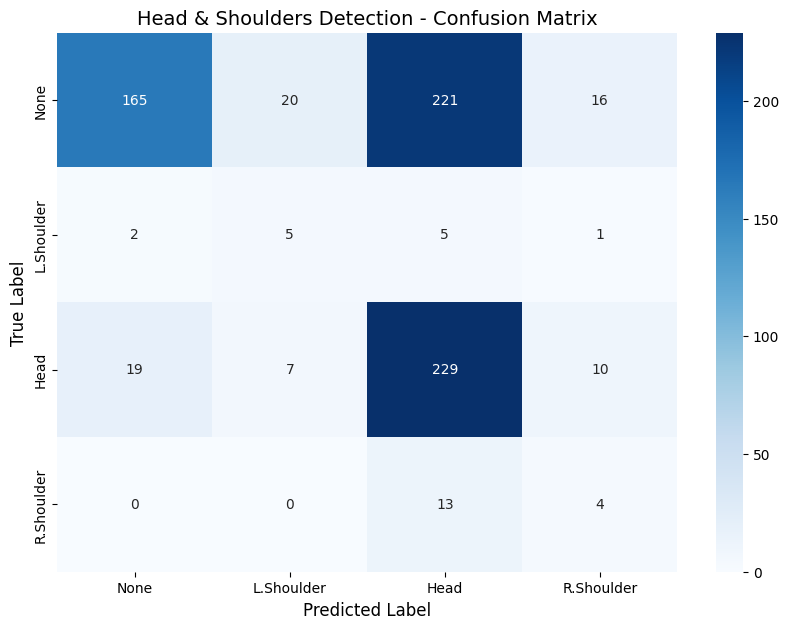


Detailed Classification Report (All Classes)
              precision    recall  f1-score   support

        None       0.89      0.39      0.54       422
  L.Shoulder       0.16      0.38      0.22        13
        Head       0.49      0.86      0.62       265
  R.Shoulder       0.13      0.24      0.17        17

    accuracy                           0.56       717
   macro avg       0.42      0.47      0.39       717
weighted avg       0.71      0.56      0.56       717



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ===============================
# 1. Predict
# ===============================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# ===============================
# 2. Define classes
# ===============================
labels = [0, 1, 2, 3]
target_names = ['None', 'L.Shoulder', 'Head', 'R.Shoulder']

# ===============================
# 3. Debug: ตรวจ distribution (สำคัญมาก)
# ===============================
print("y_test distribution :", np.unique(y_test, return_counts=True))
print("y_pred distribution :", np.unique(y_pred, return_counts=True))

# ===============================
# 4. Confusion Matrix (Fix class mismatch)
# ===============================
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Head & Shoulders Detection - Confusion Matrix', fontsize=14)
plt.show()

# ===============================
# 5. Classification Report (Fix ERROR)
# ===============================
print("\n" + "="*70)
print("Detailed Classification Report (All Classes)")
print("="*70)

print(classification_report(
    y_test,
    y_pred,
    labels=labels,                 # ⭐ สำคัญที่สุด
    target_names=target_names,
    zero_division=0
))


✅ Cell 11: Confidence Threshold (คัดกรองความเชื่อมั่น)

In [ ]:

import numpy as np
import pandas as pd

# 1. ตั้งค่าความมั่นใจ (0.0 - 1.0) 
CONFIDENCE_THRESHOLD = 0.4
# 2. ทำนายผลเป็นค่า Probability
y_pred_probs = model.predict(X_test)

# 3. สร้าง List ใหม่ที่เก็บเฉพาะค่าที่ผ่านเกณฑ์
y_refined = []
for prob in y_pred_probs:
    max_val = np.max(prob)      # ค่าความมั่นใจสูงสุดในบรรดา 4 คลาส
    pred_class = np.argmax(prob) # คลาสที่โมเดลเลือก
    
    # ถ้าความมั่นใจไม่ถึงเกณฑ์ ให้ปัดเป็นคลาส 0 (None) ทันที
    if max_val >= CONFIDENCE_THRESHOLD:
        y_refined.append(pred_class)
    else:
        y_refined.append(0)

y_refined = np.array(y_refined)

# แสดงสถิติหลังการกรอง
unique, counts = np.unique(y_refined, return_counts=True)
print("จำนวนที่ AI ทายก่อนใช้ Threshold:", pd.Series(y_pred).value_counts())
print(dict(zip(['None', 'L.Shoulder', 'Head', 'R.Shoulder'], counts.tolist() if len(counts)==4 else counts)))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
จำนวนที่ AI ทายก่อนใช้ Threshold: 2    468
0    186
1     32
3     31
Name: count, dtype: int64
{'None': 312, 'L.Shoulder': 4, 'Head': 389, 'R.Shoulder': 12}


✅ Cell 12: Sequence Verification (ตรวจสอบรูปทรงตามลำดับ)

In [ ]:


def verify_sequence_flexible(preds, gap=20):
    """
    ตรวจสอบการเรียงลำดับ 1 -> 2 -> 3 โดยยอมให้มีระยะห่าง (gap) ระหว่างกัน
    """
    found_patterns = []
    n = len(preds)
    
    for i in range(n - gap*2):
        if preds[i] == 1: # 1. พบไหล่ซ้าย (L.Shoulder)
            # 2. ค้นหาหัว (Head) ในระยะถัดไปไม่เกิน gap
            for j in range(i + 1, min(i + gap, n)):
                if preds[j] == 2:
                    # 3. ค้นหาไหล่ขวา (R.Shoulder) ในระยะถัดไปไม่เกิน gap
                    for k in range(j + 1, min(j + gap, n)):
                        if preds[k] == 3:
                            found_patterns.append({
                                'L_idx': i,
                                'H_idx': j,
                                'R_idx': k
                            })
                            break # เจอครบชุดแล้ว ออกจาก Loop ใน
                    if found_patterns and found_patterns[-1]['H_idx'] == j:
                        break
    return found_patterns

# รันการตรวจสอบลำดับ

final_signals = verify_sequence_flexible(y_refined, gap=60)

print(f"✅ ตรวจพบรูปแบบ Head & Shoulders ที่สมบูรณ์ทั้งหมด: {len(final_signals)} ชุด")

if len(final_signals) == 0:
    print("ยังไม่เจอ Pattern แบบครบชุด... กำลังลองค้นหาเฉพาะ 'หัว (Head)' ที่มั่นใจสูง:")
    heads = np.where(y_refined == 2)[0]
    print(f"พบจุดที่เป็น 'หัว' ทั้งหมด {len(heads)} จุด")
    


✅ ตรวจพบรูปแบบ Head & Shoulders ที่สมบูรณ์ทั้งหมด: 1 ชุด


✅ Cell 13: Visualization Dashboard (พื้นฐาน)

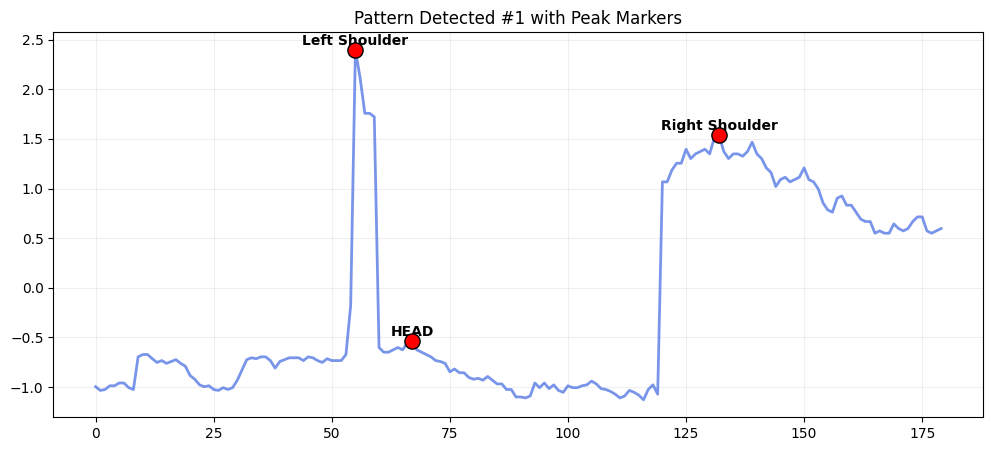

In [ ]:

from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def display_h_s_with_peaks(signals, X_data):
    if not signals:
        print("ยังไม่พบรูปแบบที่สมบูรณ์")
        return

    for i, sig in enumerate(signals):
        # 1. ดึงราคาจาก Windows ที่ AI เลือกไว้ (ใช้ Index 3 = Close Price)
        ls_part = X_data[sig['L_idx']][:, 3]
        h_part = X_data[sig['H_idx']][:, 3]
        rs_part = X_data[sig['R_idx']][:, 3]
        combined = np.concatenate([ls_part, h_part, rs_part])
        
        # 2. ค้นหาจุดที่สูงที่สุดในแต่ละช่วง (60 แท่งต่อส่วน)
        # หา Peak ในช่วงไหล่ซ้าย (0-60), หัว (60-120), ไหล่ขวา (120-180)
        p_l, _ = find_peaks(combined[0:60])
        p_h, _ = find_peaks(combined[60:120])
        p_r, _ = find_peaks(combined[120:180])

        # เลือกจุดยอดที่สูงที่สุดจริงๆ ในแต่ละโซน
        idx_l = p_l[np.argmax(combined[p_l])]
        idx_h = p_h[np.argmax(combined[60+p_h])] + 60
        idx_r = p_r[np.argmax(combined[120+p_r])] + 120

        # 3. พล็อตกราฟ
        plt.figure(figsize=(12, 5))
        plt.plot(combined, color='royalblue', alpha=0.7, label='Price Action', lw=2)
        
        # มาร์คจุดยอดสีแดง
        peaks_x = [idx_l, idx_h, idx_r]
        peaks_y = [combined[idx_l], combined[idx_h], combined[idx_r]]
        plt.scatter(peaks_x, peaks_y, color='red', s=120, edgecolors='black', zorder=5)
        
        # เขียนชื่อกำกับแต่ละจุด
        labels = ['Left Shoulder', 'HEAD', 'Right Shoulder']
        for x, y, label in zip(peaks_x, peaks_y, labels):
            plt.text(x, y + 0.05, label, fontsize=10, fontweight='bold', ha='center')

        plt.title(f"Pattern Detected #{i+1} with Peak Markers")
        plt.grid(True, alpha=0.2)
        plt.show()

# เรียกใช้งานโดยส่งสัญญาณที่กรองแล้วเข้าไป
display_h_s_with_peaks(final_signals, X_test)